In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect, LangDetectException
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
tqdm.pandas()

In [3]:
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')

In [4]:
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

In [5]:
DATASET_PATH = 'Datasets/processed_english_dataset.csv'
df = pd.read_csv(DATASET_PATH)

In [6]:
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (691244, 2)


In [7]:
print(df.head())

                                                text  label
0  rwanda is set to host the headquarters of unit...      1
1  it sucks for me since im focused on the nature...      0
2  shawntarloff itsmieu you can also relate this ...      2
3  social security constant political crises dist...      0
4  filmthepolicela a broken rib can puncture a lu...      0


In [8]:
print(df.isnull().sum())

text     0
label    0
dtype: int64


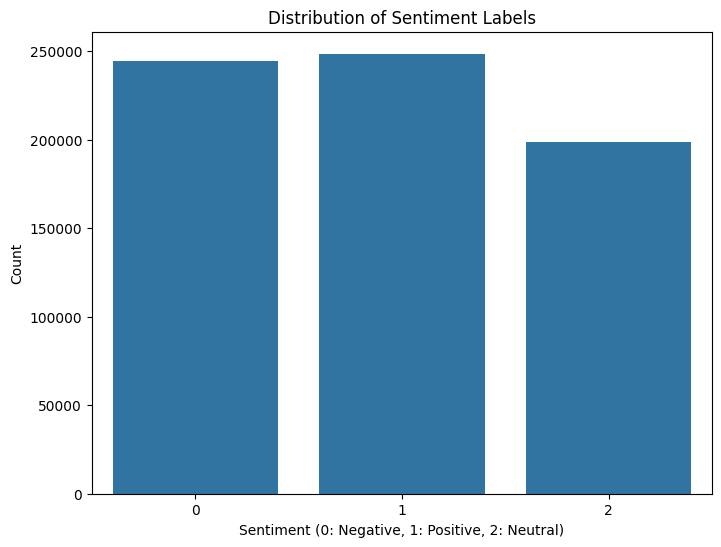

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment (0: Negative, 1: Positive, 2: Neutral)')
plt.ylabel('Count')
plt.show()

In [10]:
df['text_length'] = df['text'].astype(str).str.len()
df['word_count'] = df['text'].astype(str).str.split().str.len()

In [11]:
print("Text Length Statistics:")
print(df.groupby('label')['text_length'].describe())

Text Length Statistics:
          count        mean        std  min   25%    50%    75%    max
label                                                                 
0      244144.0  147.504546  90.467937  4.0  70.0  131.0  225.0  885.0
1      248514.0  133.564411  84.032034  3.0  61.0  116.0  205.0  855.0
2      198586.0  146.480759  84.043070  4.0  77.0  131.0  213.0  864.0


In [12]:
print("\nWord Count Statistics:")
print(df.groupby('label')['word_count'].describe())


Word Count Statistics:
          count       mean        std  min   25%   50%   75%    max
label                                                              
0      244144.0  25.982228  15.635015  0.0  12.0  23.0  39.0  106.0
1      248514.0  22.971318  14.635454  1.0  10.0  20.0  34.0  107.0
2      198586.0  25.817973  14.565687  1.0  13.0  23.0  37.0  107.0


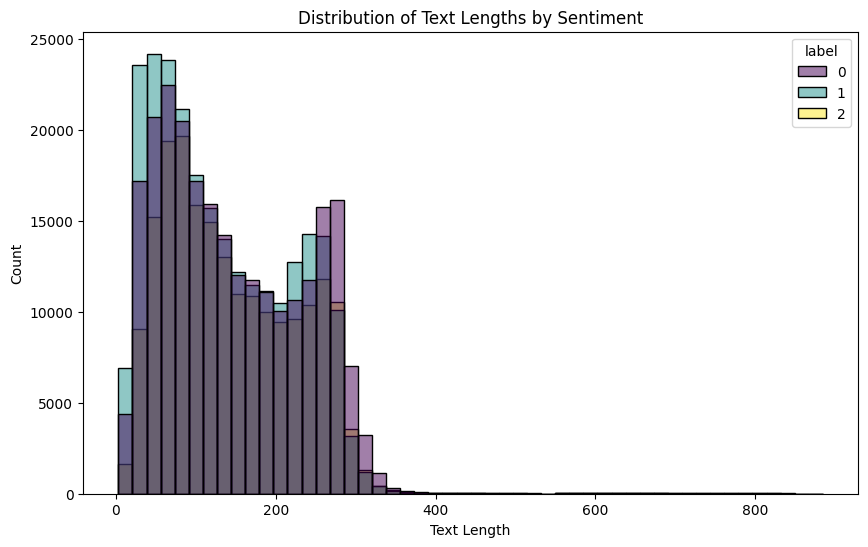

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, palette='viridis')
plt.title('Distribution of Text Lengths by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

In [14]:
def safe_detect_language(text):
    """Safely detect language, returning 'unknown' on error or for empty text."""
    try:
        if isinstance(text, str) and text.strip():
            return detect(text)
        else:
            return 'unknown'
    except LangDetectException:
        return 'unknown'

In [15]:
df['language'] = df['text'].progress_apply(safe_detect_language)
print("\nLanguages Detected:")
print(df['language'].value_counts().head(10))

100%|██████████| 691244/691244 [11:23<00:00, 1010.92it/s] 


Languages Detected:
language
en    662258
af      3218
cy      2442
so      2410
nl      2128
fr      1989
ca      1979
no      1726
da      1533
et      1345
Name: count, dtype: int64


In [16]:
def clean_text_phase1(text):
    """
    Initial text cleaning: lowercase, remove URLs, mentions, special characters, and digits.
    """
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep only alphabetic chars and spaces
    text = re.sub(r'\d+', '', text) # Remove digits
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces with a single one
    return text

In [17]:
STOP_WORDS_ENGLISH = set(stopwords.words('english'))

In [18]:
def remove_stopwords_from_tokens(text_cleaned):
    """
    Tokenizes text, removes stopwords, and filters for non-alphabetic tokens.
    """
    if not text_cleaned or pd.isna(text_cleaned):
        return "" # Return empty string for empty/NaN input
    
    tokens = word_tokenize(text_cleaned)
    filtered_tokens = [
        word for word in tokens if word.isalpha() and word not in STOP_WORDS_ENGLISH
    ]
    return ' '.join(filtered_tokens)

In [19]:
df['text_clean'] = df['text'].progress_apply(clean_text_phase1)

100%|██████████| 691244/691244 [00:04<00:00, 166711.05it/s]


In [20]:
print(f"Original size: {len(df)}. Filtering for English text...")
df_english = df[df['language'] == 'en'].copy()
print(f"Size after filtering for English: {len(df_english)}")

Original size: 691244. Filtering for English text...
Size after filtering for English: 662258


In [21]:
df_english['text_clean'] = df_english['text_clean'].progress_apply(remove_stopwords_from_tokens)

100%|██████████| 662258/662258 [00:21<00:00, 31260.44it/s]


In [22]:
df_english.dropna(subset=['text_clean', 'label'], inplace=True)
df_english = df_english[df_english['text_clean'].str.strip().astype(bool)]
df_english.reset_index(drop=True, inplace=True)

In [23]:
df_final_cleaned = df_english[['text_clean', 'label']].copy()

In [24]:
print(f"Final dataset shape: {df_final_cleaned.shape}")

Final dataset shape: (662253, 2)


In [25]:
print("Final value counts (proportional):")
print(df_final_cleaned['label'].value_counts(normalize=True))
print("\nFirst 5 rows of cleaned data:")
print(df_final_cleaned.head())

Final value counts (proportional):
label
1    0.356796
0    0.350840
2    0.292364
Name: proportion, dtype: float64

First 5 rows of cleaned data:
                                          text_clean  label
0  rwanda set host headquarters united nations de...      1
1  sucks since im focused nature aspect things en...      0
2  shawntarloff itsmieu also relate art lot peopl...      2
3  social security constant political crises dist...      0
4  filmthepolicela broken rib puncture lung lead ...      0


In [26]:
sentiment_labels = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}

In [27]:
def generate_wordcloud(text_data, title):
    """Generates and plots a word cloud from the given text data."""
    text = ' '.join(text_data)
    if not text:
        print(f"No text data to generate word cloud for {title}.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

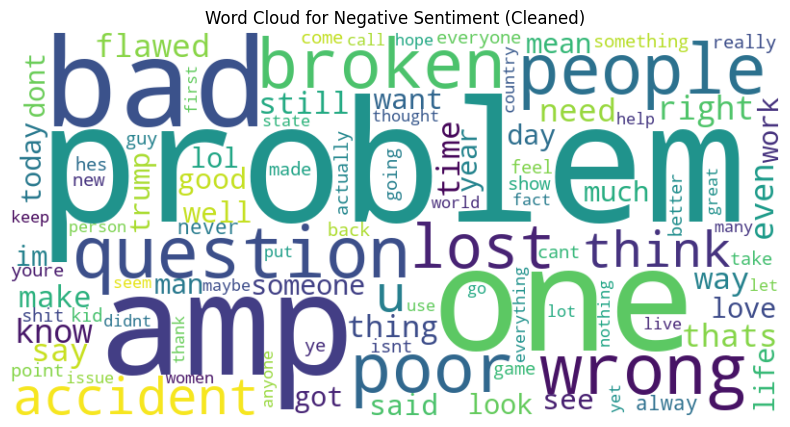

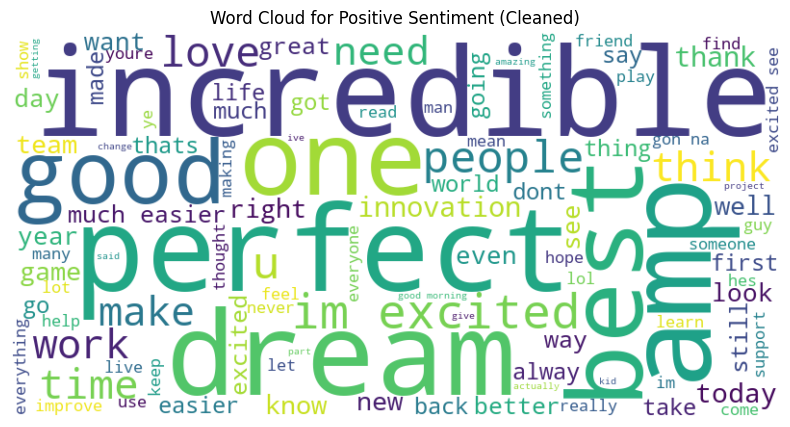

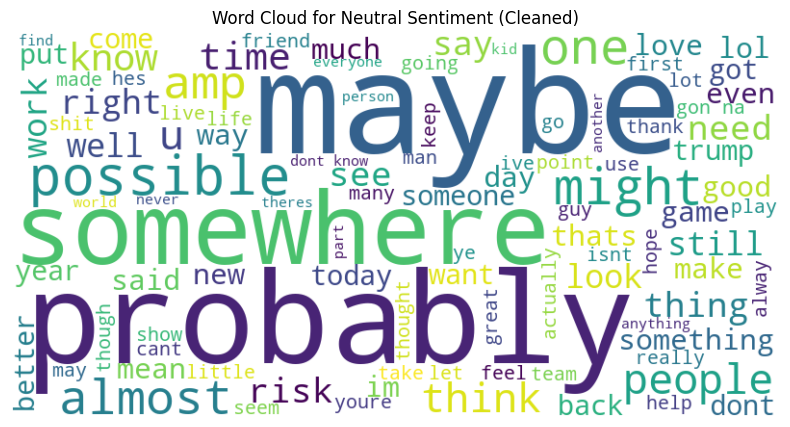

In [28]:
for label, sentiment in sentiment_labels.items():
    text_data = df_final_cleaned[df_final_cleaned['label'] == label]['text_clean'].dropna()
    if not text_data.empty:
        generate_wordcloud(text_data, f'Word Cloud for {sentiment} Sentiment (Cleaned)')

In [29]:
def plot_top_n_grams(corpus, title, n=2, top_k=15, sentiment_label_for_palette="Positive"):
    """Plots the most frequent n-grams in a given text corpus."""
    palette_colors = {'Positive': 'Greens_r', 'Negative': 'Reds_r', 'Neutral': 'Blues_r'}
    try:
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        
        if not words_freq:
            print(f"No {n}-grams found for '{title}'.")
            return
            
        top_df = pd.DataFrame(words_freq[:top_k], columns=['Ngram', 'Frequency'])

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Frequency', y='Ngram', data=top_df, palette=palette_colors.get(sentiment_label_for_palette, 'viridis'))
        plt.title(title)
        plt.xlabel('Frequency')
        plt.ylabel(f'{n}-gram')
        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Could not generate n-grams for {title}: {e}")


Processing Negative sentiment for N-grams...


/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_6105/556825037.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=top_df, palette=palette_colors.get(sentiment_label_for_palette, 'viridis'))


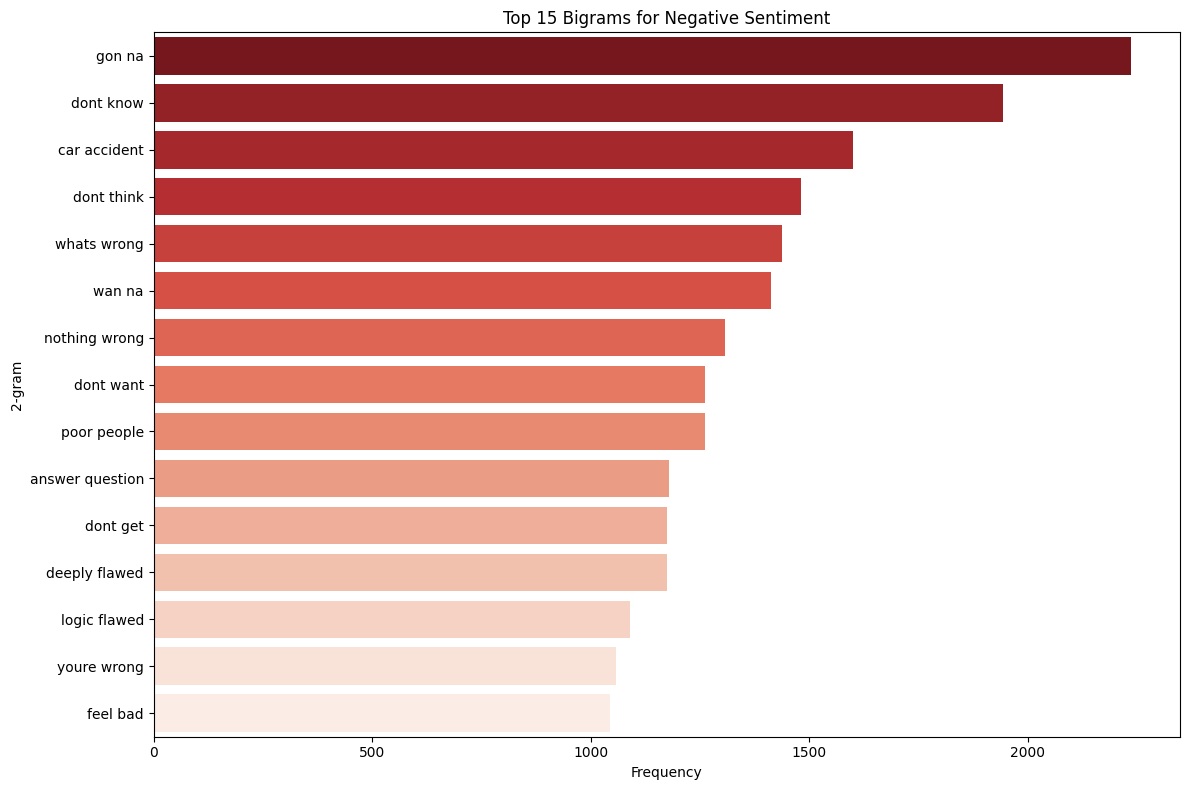

/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_6105/556825037.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=top_df, palette=palette_colors.get(sentiment_label_for_palette, 'viridis'))


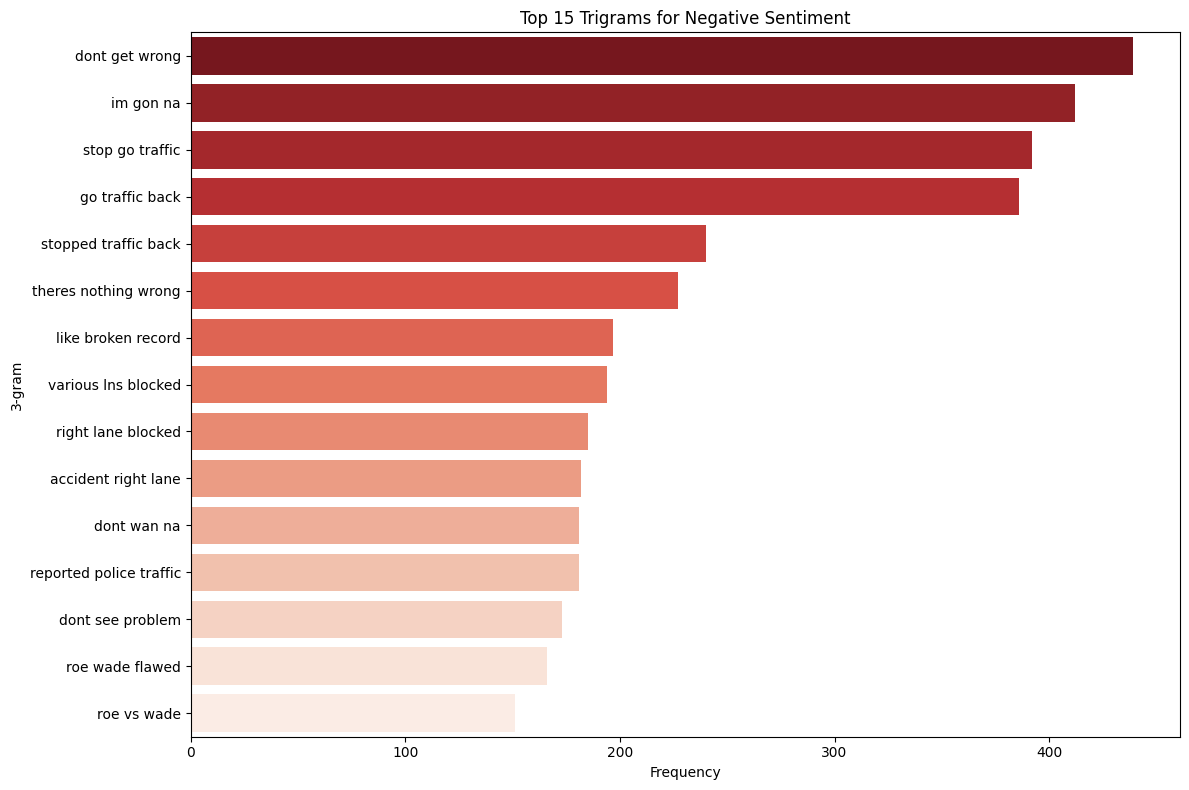


Processing Positive sentiment for N-grams...


/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_6105/556825037.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=top_df, palette=palette_colors.get(sentiment_label_for_palette, 'viridis'))


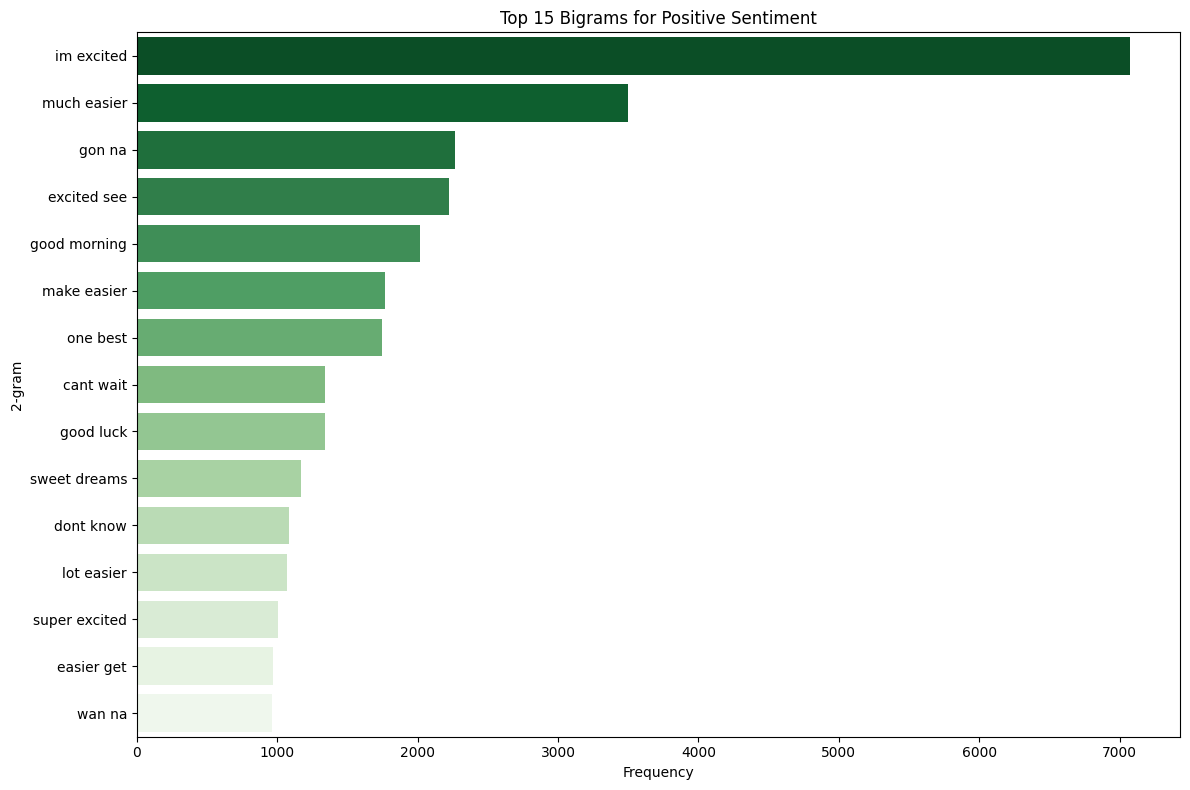

/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_6105/556825037.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=top_df, palette=palette_colors.get(sentiment_label_for_palette, 'viridis'))


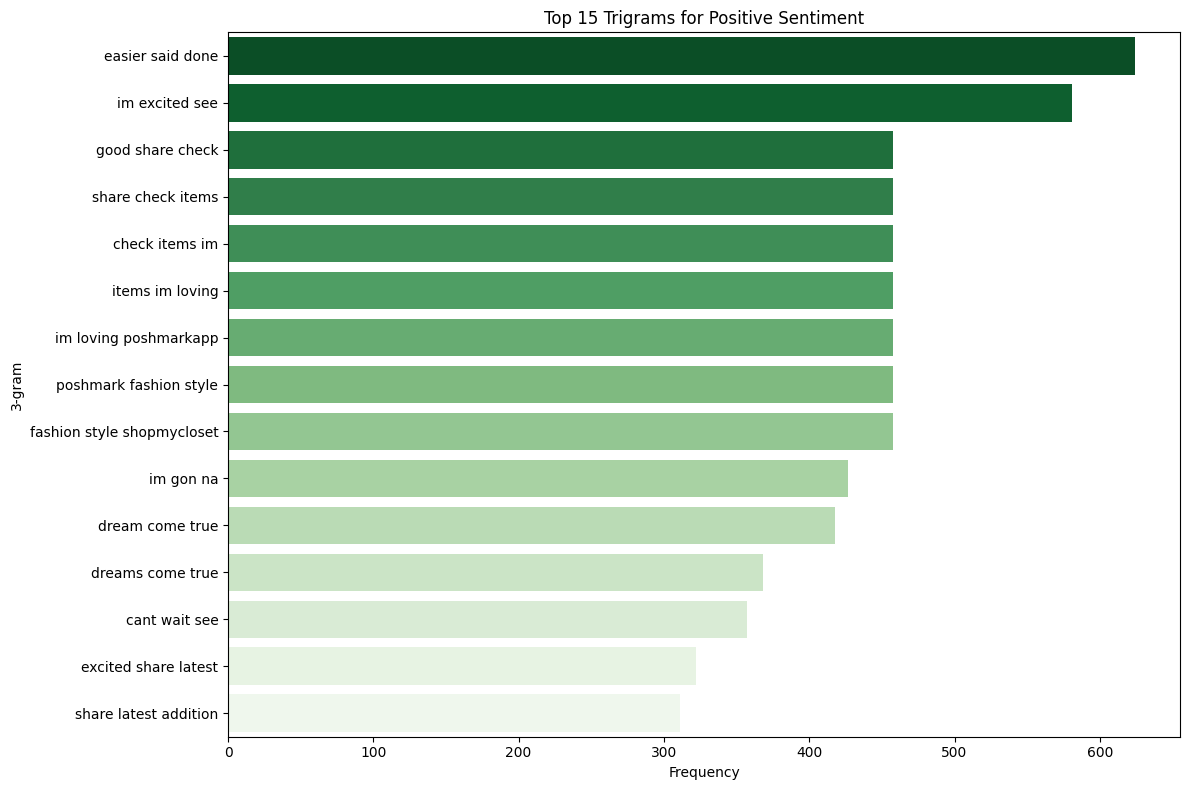


Processing Neutral sentiment for N-grams...


/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_6105/556825037.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=top_df, palette=palette_colors.get(sentiment_label_for_palette, 'viridis'))


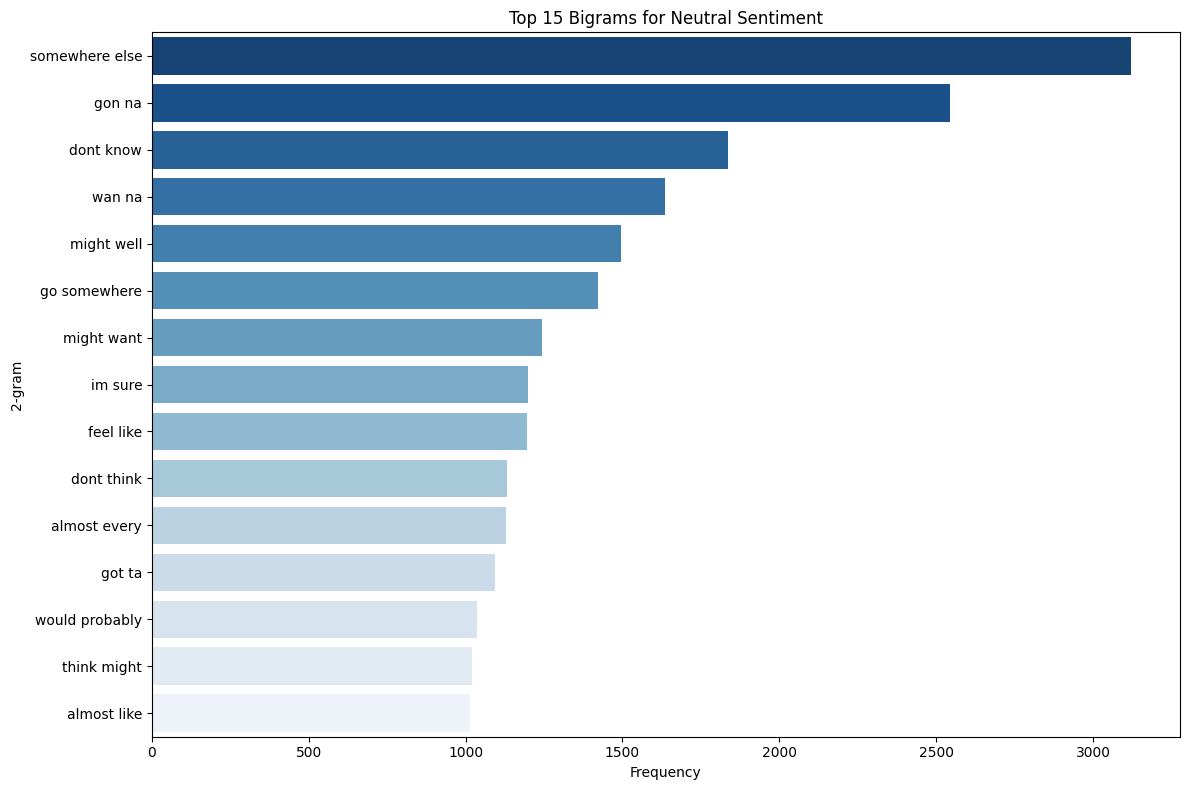

/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_6105/556825037.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=top_df, palette=palette_colors.get(sentiment_label_for_palette, 'viridis'))


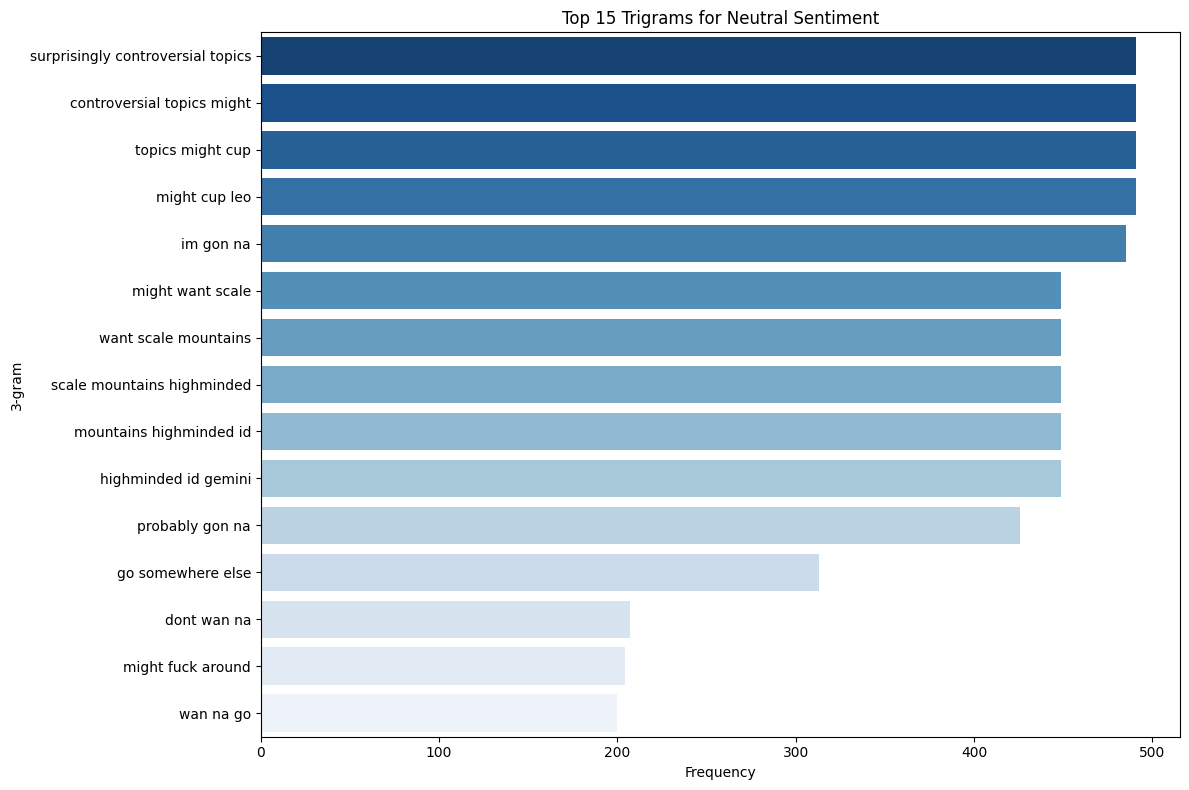

In [30]:
for label_code, sentiment_name in sentiment_labels.items():
    print(f"\nProcessing {sentiment_name} sentiment for N-grams...")
    sentiment_data = df_final_cleaned[df_final_cleaned['label'] == label_code]['text_clean'].dropna()
    
    # Plot Bigrams
    plot_top_n_grams(sentiment_data,
                     title=f'Top 15 Bigrams for {sentiment_name} Sentiment',
                     n=2, top_k=15, sentiment_label_for_palette=sentiment_name)
    
    # Plot Trigrams
    plot_top_n_grams(sentiment_data,
                     title=f'Top 15 Trigrams for {sentiment_name} Sentiment',
                     n=3, top_k=15, sentiment_label_for_palette=sentiment_name)


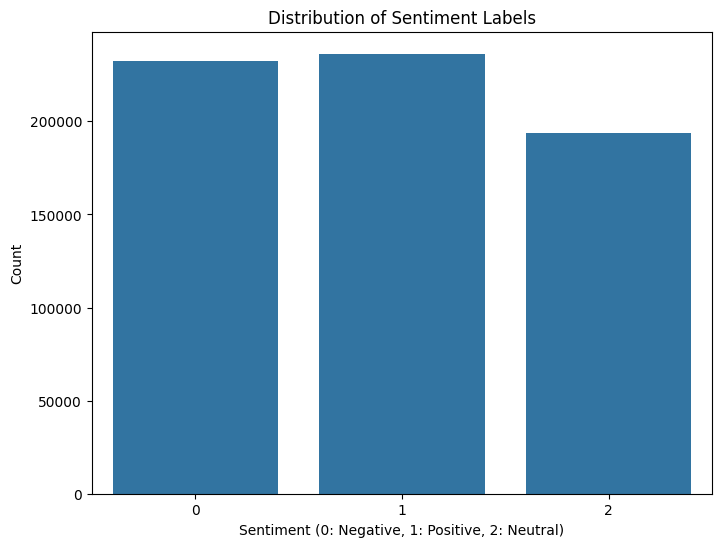

In [31]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_final_cleaned, x='label')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment (0: Negative, 1: Positive, 2: Neutral)')
plt.ylabel('Count')
plt.show()

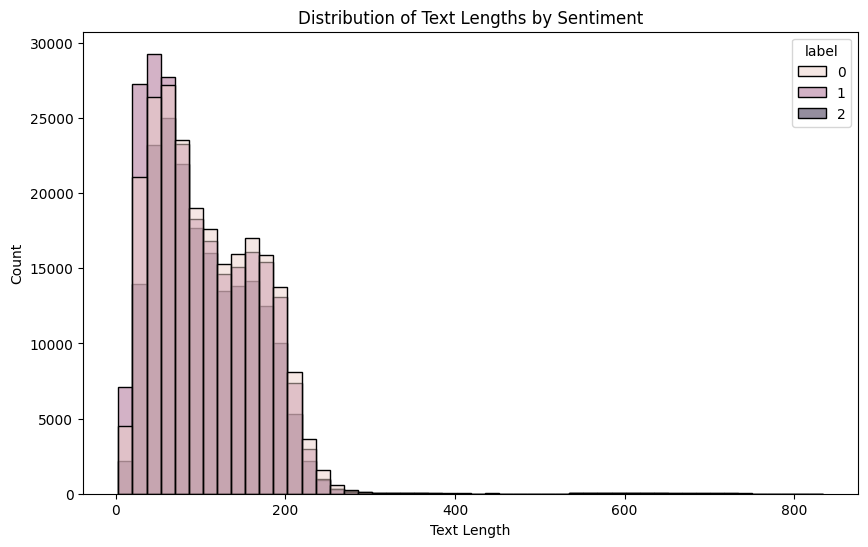

In [32]:
df_final_cleaned['text_clean_length'] = df_final_cleaned['text_clean'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data=df_final_cleaned, x='text_clean_length', hue='label', bins=50)
plt.title('Distribution of Text Lengths by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

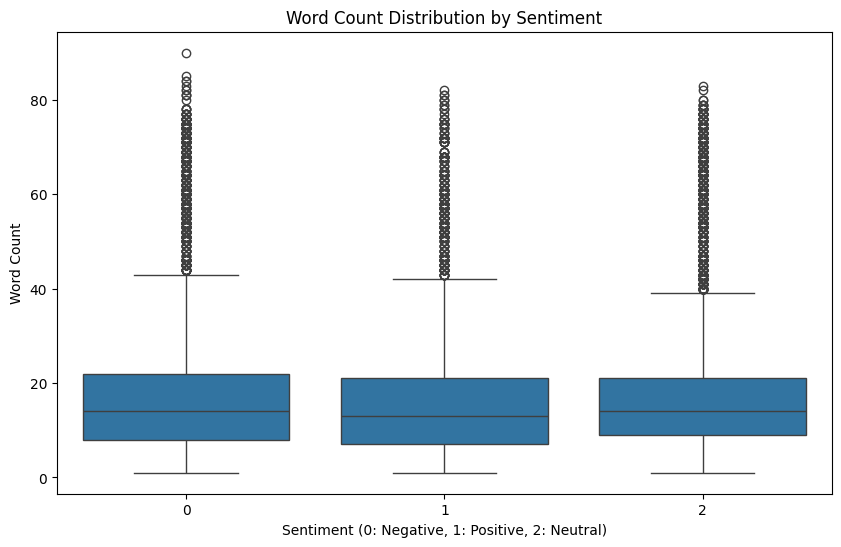

In [33]:
df_final_cleaned['word_count_cleaned'] = df_final_cleaned['text_clean'].str.split().str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final_cleaned, x='label', y='word_count_cleaned')
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive, 2: Neutral)')
plt.ylabel('Word Count')
plt.show()

In [34]:
output_directory = 'Datasets'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [35]:
output_file_path = os.path.join(output_directory, 'processed_english_final.parquet')
df_final_cleaned.to_parquet(output_file_path, index=False)

# Training

In [36]:
import os
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from evaluate  import load as load_metric

In [38]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU (CUDA) for computations.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS) for computations.")
else:
    device = torch.device("cpu")
    print("Neither CUDA nor MPS available. Using CPU for computations.")

Using Apple Silicon GPU (MPS) for computations.


In [39]:
MODEL_ID = "distilbert-base-uncased"
DATASET_PATH = 'Datasets/processed_english_final.parquet'
TEXT_COLUMN = 'text_clean'
LABEL_COLUMN = 'label'
NUM_LABELS = 3
ID2LABEL = {0: "negative", 1: "positive", 2: "neutral"}
LABEL2ID = {v: k for k, v in ID2LABEL.items()}

### Reading Dataset Again:
- Not necessary to do this again. This notebook was a combination of several different datasets. Hence some steps are repeated

In [40]:
df = pd.read_parquet(DATASET_PATH)
df.head()

,text_clean,label,text_clean_length,word_count_cleaned
0,rwanda set host headquarters united nations de...,1,153,18
1,sucks since im focused nature aspect things en...,0,200,27
2,shawntarloff itsmieu also relate art lot peopl...,2,179,27
3,social security constant political crises dist...,0,182,26
4,filmthepolicela broken rib puncture lung lead ...,0,101,14


In [41]:
if TEXT_COLUMN not in df.columns or LABEL_COLUMN not in df.columns:
    raise ValueError(
        f"CSV must contain '{TEXT_COLUMN}' and '{LABEL_COLUMN}' columns."
    )

In [42]:
df.dropna(subset=[TEXT_COLUMN, LABEL_COLUMN], inplace=True)
df[LABEL_COLUMN] = df[LABEL_COLUMN].astype(int)

In [43]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[LABEL_COLUMN]
)

In [44]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
print(train_dataset[0])
print(test_dataset[0])

{'text_clean': 'recipes make morning routine much easier breakfast', 'label': 1, 'text_clean_length': 50, 'word_count_cleaned': 7, '__index_level_0__': 638375}
{'text_clean': 'kingpapiyolo davidgokhshtein friend bitcoin getting fired crypto pizza maybe bb excellent opportunity growth innovation', 'label': 1, 'text_clean_length': 119, 'word_count_cleaned': 14, '__index_level_0__': 213845}


In [45]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [46]:
def tokenize_function(examples):
    """
    Tokenizes the text data. Padding and truncation are handled to ensure
    all sequences have the same length.
    """
    return tokenizer(
        examples[TEXT_COLUMN], padding="max_length", truncation=True, max_length=512
    )

In [47]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/529802 [00:00<?, ? examples/s]

Map:   0%|          | 0/132451 [00:00<?, ? examples/s]

In [48]:
tokenized_train_dataset = tokenized_train_dataset.remove_columns([TEXT_COLUMN])
tokenized_test_dataset = tokenized_test_dataset.remove_columns([TEXT_COLUMN])

In [49]:
print(F"using {device} for computations")

using mps for computations


In [50]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=NUM_LABELS,
    id2label=ID2LABEL,
    label2id=LABEL2ID,
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
print(model.config)

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "positive",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 0,
    "neutral": 2,
    "positive": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "vocab_size": 30522
}



In [52]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",
)

In [53]:
peft_model = get_peft_model(model, peft_config)

'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/chyavanshenoy/Desktop/UniProjectGithub/AAI-510-Project/.venv/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [54]:
peft_model.print_trainable_parameters()

trainable params: 887,811 || all params: 67,843,590 || trainable%: 1.3086


In [55]:
accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

In [56]:
def compute_metrics(eval_pred):
    """
    Computes and returns a dictionary of metrics for evaluation.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [57]:
training_args = TrainingArguments(
    output_dir="./distilbert-sentiment-english-lora-mps-model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # fp16 is not fully supported on MPS, so we disable it for stability.
    # PyTorch will automatically use mixed precision where available on MPS.
    fp16=False,
    save_safetensors=True,
    report_to="none"
)

In [58]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_6105/2791733472.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.234400,0.158233,0.945527,0.946267,0.945527,0.945608
400,0.142600,0.097294,0.964236,0.964440,0.964236,0.964281


In [ ]:
final_model_path = "./English_DistilBERT_Model"
trainer.save_model(final_model_path)

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)